In [1]:
import torchvision

from torch import cuda, device, Tensor
from src.plots import plot_vae_training_result, plot_cifar_image
from src.vae.cifar_vae import ConditionalVae
from src.image_classifier.image_classifier import CIFAR10Classifier

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
# convert data to a normalized torch.FloatTensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_train', train=True, download=True, transform=transform)
testing_data = torchvision.datasets.CIFAR10(root='../data/CIFAR10_test', train=False, download=True, transform=transform)

print(training_data)
print(testing_data)

input = training_data.data[:50000]
labels = training_data.targets[:50000]

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/CIFAR10_train
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data/CIFAR10_test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [3]:
# Train VAE
vae = ConditionalVae(dim_encoding=64).to(device)

vae_model, vae_loss_li, kl_loss_li = vae.train_model(
    training_data=training_data,
    batch_size=32,
    epochs=1,
    learning_rate=0.001
)

/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Finished epoch:  1


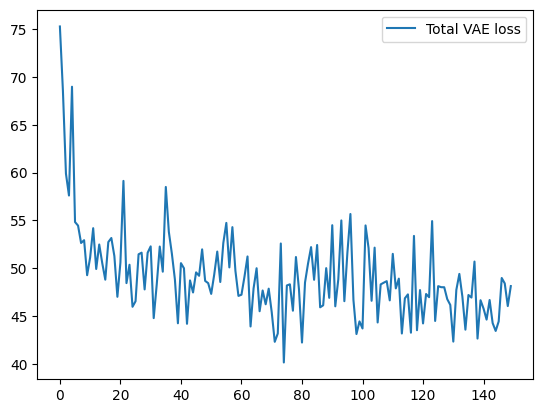

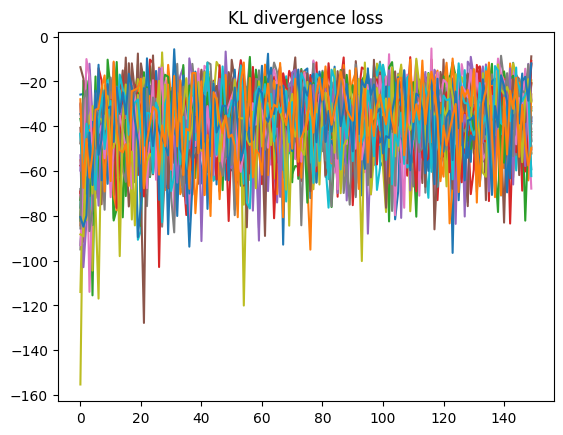

In [4]:
# move tensors to cpu before converting to np array
np_kl_loss_li = []

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())

# plot results
plot_vae_training_result(
    input=input,
    labels=labels,
    vae_model=vae_model,
    vae_loss_li=vae_loss_li,
    kl_loss_li=np_kl_loss_li
)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


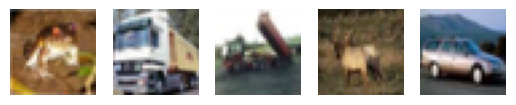

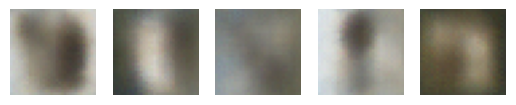

In [4]:
# check output
n_samples = 5

samples = training_data.data[:n_samples]
plot_cifar_image(samples)

"""
airplane 										
automobile 										
bird 										
cat 										
deer 										
dog 										
frog 										
horse 										
ship 										
truck
"""
output = vae.generate_data(n_samples=n_samples, target_label=0)

# vae expects permuted input of (<bath_size, channels, height, width>)
output = output.permute(0, 3, 2, 1).cpu().detach().numpy()

assert output.shape == (n_samples, 32, 32, 3)

plot_cifar_image(output)

In [ ]:
# train classifier for performance evaluation
classifier = CIFAR10Classifier().to(device)

classifier.train_model(training_data, batch_size=32, learning_rate=0.01, epochs=20)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

In [ ]:
# x = vae.generate_data(n_samples=10000)
# print("Number of images: ", x.shape[0])
# 
# labels = classifier.generate_labels(x)
# print("Labels: ", labels.shape)

In [ ]:
# # Determine FID
# # generate 500 images
# syn_input, _ = vae.generate_data(n_samples=500)
# input = input[:500]
# 
# input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
# 
# # compute FID score
# fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
# print("Frechet Inception Distance: ", fid_score)